# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек 

In [1]:
from scipy import stats
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


<a id="H0"></a>

## Тестирование гипотез

### Гипотеза для коэффициента корелляции

# Поработаем с датасетом c покупками

Метрики
ARPU или Average Revenue Per User - является производным показателем, рассчитывается как средневзвешенное за период агрегации значение Платежи LT/Регистрации. Отображает прибыль, полученную нами с 1 регистрации пользователя, также известен.

ARPPU или Average Revenue Per Paying User - средний платеж платящего пользователя. Рассчитывается как средневзвешенное значение (Платежи LT/Впервые заплативших LT) за период агрегации. Показывает, сколько, в среднем, платит пользователь, ставший платящим, и, зарегистрированный в период агрегации, за всю жизнь.



# Подготовка данных

In [3]:
data = pd.read_csv('ab_stats.csv')

data.head(10)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [5]:
data.shape

(23652, 5)

In [6]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [7]:
data = data[(data['av_site visit']>=0)]

In [8]:
data.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [9]:
data.ab_group.value_counts()

ab_group
A    11829
B    11355
Name: count, dtype: int64

In [10]:
data[data['purchase']==1]

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


Посмотрим на группы отдельно

In [11]:
data[data['ab_group']=='A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11829.000000,11829.000000,11829.000000,11829.000000
mean,0.404667,0.050723,0.021642,6.980379
std,13.136545,1.467883,0.145517,2.004450
min,0.000000,0.000000,0.000000,0.145466
25%,0.000000,0.000000,0.000000,5.657590
50%,0.000000,0.000000,0.000000,6.984166
75%,0.000000,0.000000,0.000000,8.346243
max,1303.609284,152.000000,1.000000,17.728836


In [12]:
data[data['ab_group']=='B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11355.000000,11355.000000,11355.000000,11355.000000
mean,0.245093,0.036548,0.019727,7.404806
std,3.192299,0.422820,0.139067,3.630412
min,0.000000,0.000000,0.000000,0.008679
25%,0.000000,0.000000,0.000000,4.746728
50%,0.000000,0.000000,0.000000,7.262590
75%,0.000000,0.000000,0.000000,9.889165
max,113.830000,25.000000,1.000000,22.446822


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в первой группе сильно больше, чем в группе B. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

# Проверка на нормальность распределения и применение статистических критериев

## Метрика визиты на юзера

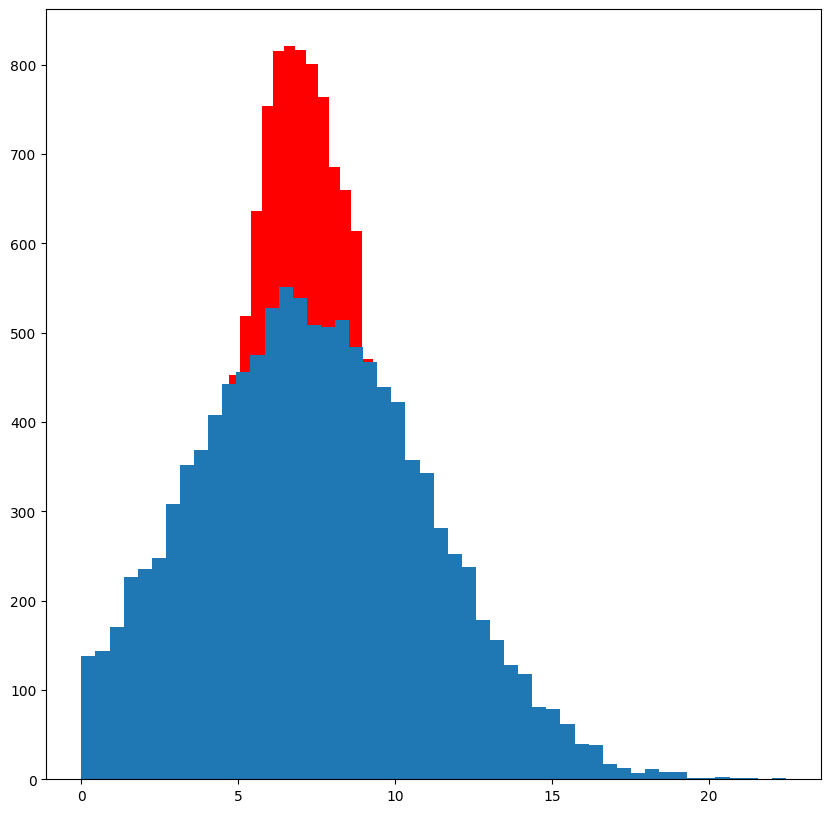

In [13]:
plt.figure(figsize=(10, 10))
control_visit_all = data['av_site visit'][data['ab_group'] == 'A']
test_visit_all =data['av_site visit'][data['ab_group'] == 'B']


plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all,  bins=50)


plt.show()

In [27]:
stats.ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=-10.957295422202266, pvalue=7.548128551839559e-28)

## Метрика доля юзеров с покупкой

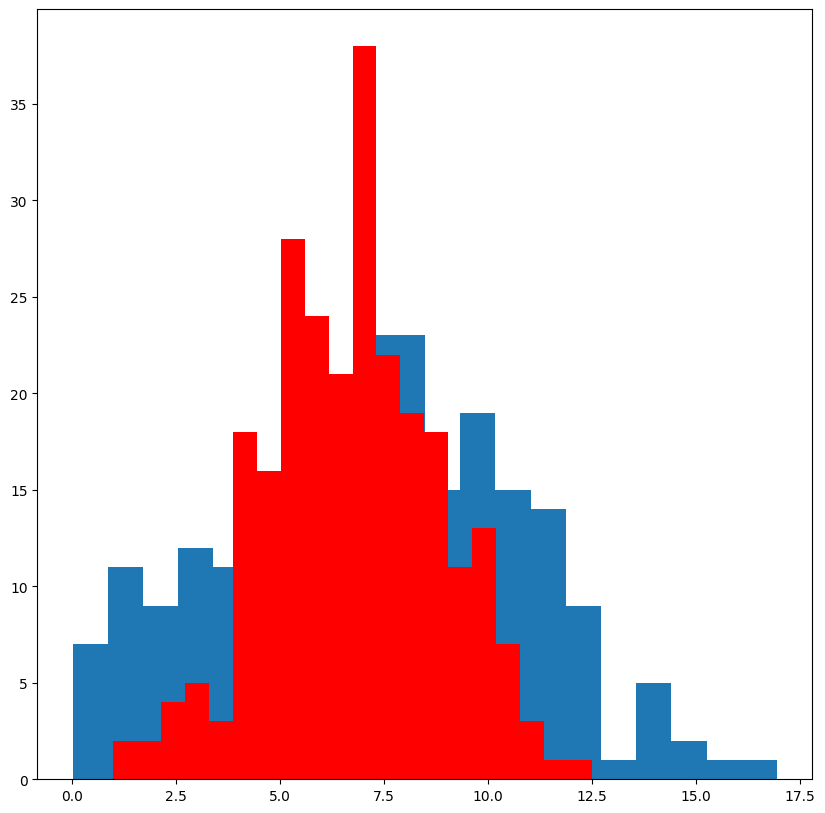

In [28]:
plt.figure(figsize=(10, 10))
control_visit = data['av_site visit'][(data['ab_group'] == 'A')&(data['purchase'] == 1)]
test_visit =data['av_site visit'][(data['ab_group'] == 'B')&(data['purchase'] == 1)]
plt.hist(test_visit,  bins=20)
plt.hist(control_visit, color='r', bins=20)

plt.show()

In [29]:
stats.ttest_ind(control_visit, test_visit, equal_var = False)

Ttest_indResult(statistic=-1.8346992509618332, pvalue=0.06740860216409701)

In [30]:
data['purchase'].value_counts()

purchase
0    22704
1      480
Name: count, dtype: int64

In [31]:
k1 = data[data['ab_group']=='A']['purchase'].sum()
k2 = data[data['ab_group']=='B']['purchase'].sum()

In [32]:
k1, k2

(256, 224)

In [33]:
n1 = data[data['ab_group']=='A'].shape[0]
n2 = data[data['ab_group']=='B'].shape[0]

In [34]:
n1, n2

(11829, 11355)

In [36]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =1.024, pvalue = 0.306


In [37]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


Непараметрический Хи-квадрат

In [38]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =1.048, pvalue = 0.306


In [39]:
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


## Метрика arpu


 Непараметрический критерий  Манн-Уитни

In [40]:
data.groupby('ab_group')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
ab_group,,,,,,,,
A,11829.0,0.404667,13.136545,0.0,0.0,0.0,0.0,1303.609284
B,11355.0,0.245093,3.192299,0.0,0.0,0.0,0.0,113.830000


In [41]:
mw_stats = stats.mannwhitneyu(x=data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'].values,
                                                  y=data[(data['ab_group'] == 'B')&(data['purchase'] == 1)]['revenue'].values)
mw_stats
#ARPPU

MannwhitneyuResult(statistic=28485.5, pvalue=0.902319344132039)

In [42]:
mw_stats = stats.mannwhitneyu(x=data[(data['ab_group'] == 'A')]['revenue'].values,
                                                  y=data[(data['ab_group'] == 'B')]['revenue'].values)
mw_stats
#ARPU

MannwhitneyuResult(statistic=67287553.0, pvalue=0.306808963067974)

Гипотезы:  
  
H0: Набор статистически значимо не влияет (p-value > 0.05)  
H1: Набор статистически значимо влияет (p-value < 0.05)  


In [44]:
import numpy as np
import pandas as pd
from scipy.stats import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

100%|██████████| 10000/10000 [00:11<00:00, 873.77it/s]


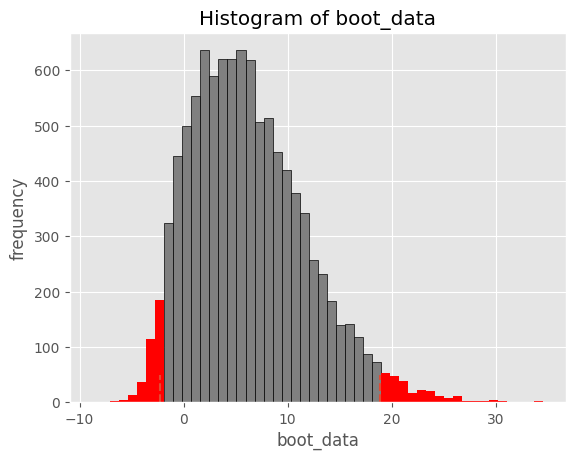

{'p_value': 0.2630880569471069}

In [45]:
get_bootstrap(data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'], data[(data['ab_group'] == 'B')&(data['purchase'] == 1)]['revenue'])

100%|██████████| 10000/10000 [00:13<00:00, 742.40it/s]


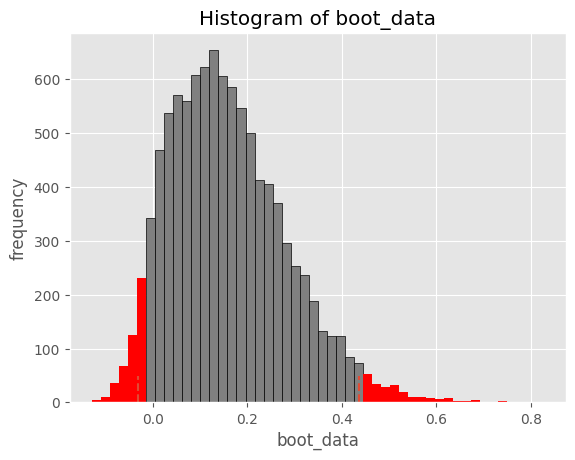

{'p_value': 0.198026695565223}

In [46]:
get_bootstrap(data[(data['ab_group'] == 'A')]['revenue'], data[(data['ab_group'] == 'B')]['revenue'])

**scipy.stats**  
функция scipy.stats.bootstrap(), появившаяся с версии 1.7.0. Содержит в себе ряд аргументов, но наиболее важные таковы:

-data — данные. Принимает их на вход в виде списка (квадратные скобки) или кортежа (круглые скобки), даже если группа только одна — в случае одной группы данные подаются как (data, );  
-statistic — функция, которая считает нужный нам параметр. Если на вход идёт две или больше групп, то функция также должна принимать на вход два или больше аргументов и возвращать какое-то одно число;  
-n_resamples — количество симуляций. По умолчанию 9999 (почти 10000) - можно понизить, если не хватает вычислительных мощностей, или повысить, если хочется увеличить точность;  
-confidence_level — уровень значимости, по умолчанию 95%;
method — алгоритм расчёта доверительного интервала. Метод по умолчанию обычно справляется лучше своих аналогов, но при необходимости можно менять.   
  
**pingouin**  
В этом пакете есть функция pingouin.compute_bootci(), во многом похожая на аналогичную из scipy - но с более простым интерфейсом, рядом встроенных метрик (смотрите описание аргумента func) и немного другим набором алгоритмов бутстрапа.

**bootstrapped**  
Библиотека от Facebook, в большей степени ориентирована на применение бутстрапа в контексте индустрии. Репозиторий содержит в себе папку с ноутбуками для демонстрации всего, что умеет делать эта библиотека.

**wildboottest**  
Эта библиотека позволяет оценивать статзначимость коэффициентов регрессионной модели с помощью бутстрапа и работает вместе со statsmodels. В частности, пакет реализует алгоритм т.н. “дикого бутстрапа”, более устойчивого к нарушениям гомоскедастичности.